Using Gymnasium (new version)

--- Run 1/3 ---

Traditional Q-Learning:


Q-Learning Training: 100%|██████████| 500/500 [00:01<00:00, 270.76it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Q-Learning Results:
  Episodes to solve: 500
  Final average reward: 43.28
  Memory usage: 0.58 MB
  Training time: 1.85 seconds

Deep Q-Learning:


Deep Q-Learning Training:  76%|███████▌  | 378/500 [4:10:58<1:21:00, 39.84s/it]

Environment solved in 379 episodes!
Deep Q-Learning Results:
  Episodes to solve: 379
  Final average reward: 196.50
  Memory usage: 226.80 MB
  Training time: 15058.84 seconds


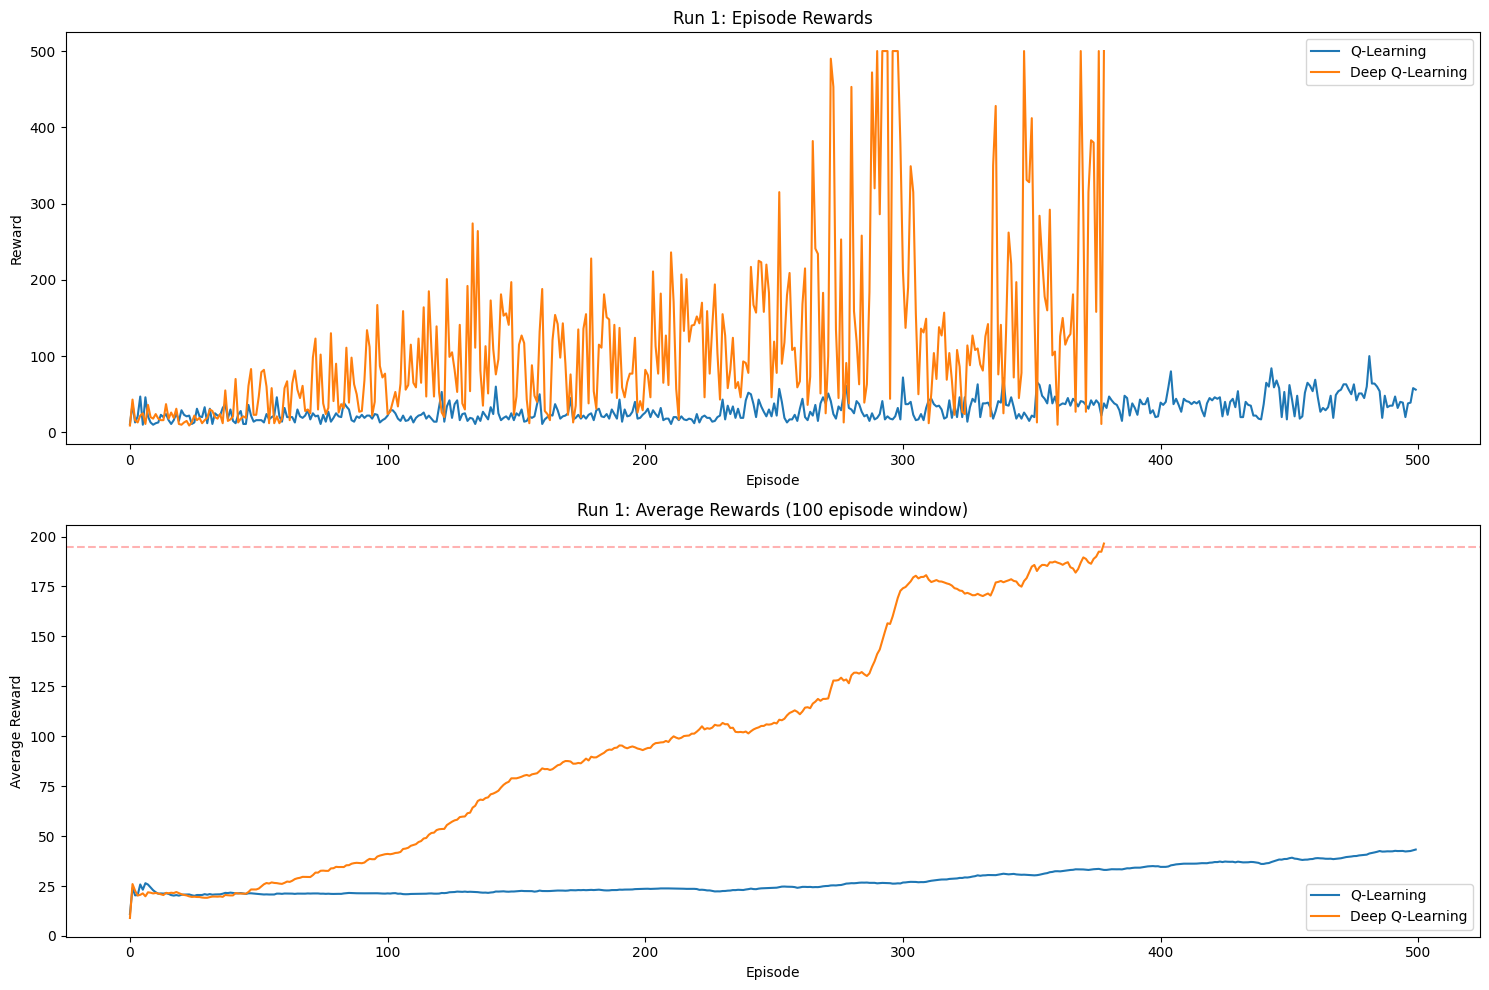


--- Run 2/3 ---

Traditional Q-Learning:


Q-Learning Training: 100%|██████████| 500/500 [00:02<00:00, 238.98it/s]


Q-Learning Results:
  Episodes to solve: 500
  Final average reward: 66.57
  Memory usage: 0.25 MB
  Training time: 2.10 seconds

Deep Q-Learning:


Deep Q-Learning Training:  57%|█████▋    | 286/500 [2:59:16<2:14:08, 37.61s/it]

Environment solved in 287 episodes!
Deep Q-Learning Results:
  Episodes to solve: 287
  Final average reward: 196.84
  Memory usage: 91.19 MB
  Training time: 10756.59 seconds


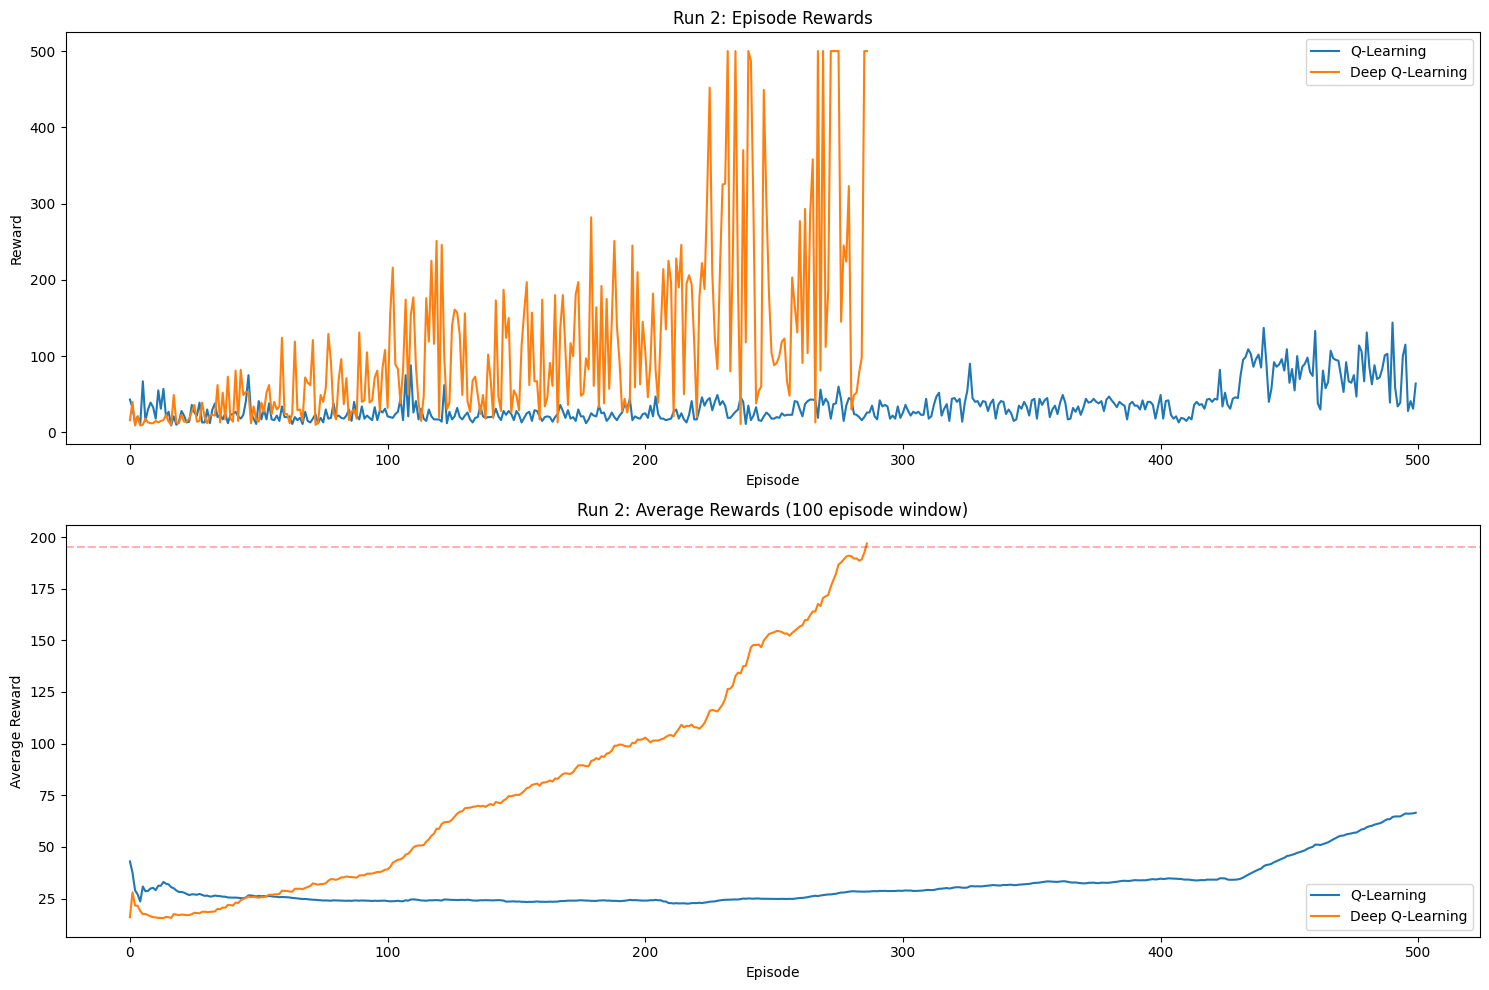


--- Run 3/3 ---

Traditional Q-Learning:


Q-Learning Training: 100%|██████████| 500/500 [00:02<00:00, 232.81it/s]


Q-Learning Results:
  Episodes to solve: 500
  Final average reward: 45.31
  Memory usage: 0.00 MB
  Training time: 2.16 seconds

Deep Q-Learning:


Deep Q-Learning Training:  82%|████████▏ | 410/500 [3:44:33<49:17, 32.86s/it]  

Environment solved in 411 episodes!
Deep Q-Learning Results:
  Episodes to solve: 411
  Final average reward: 195.82
  Memory usage: 140.89 MB
  Training time: 13473.51 seconds


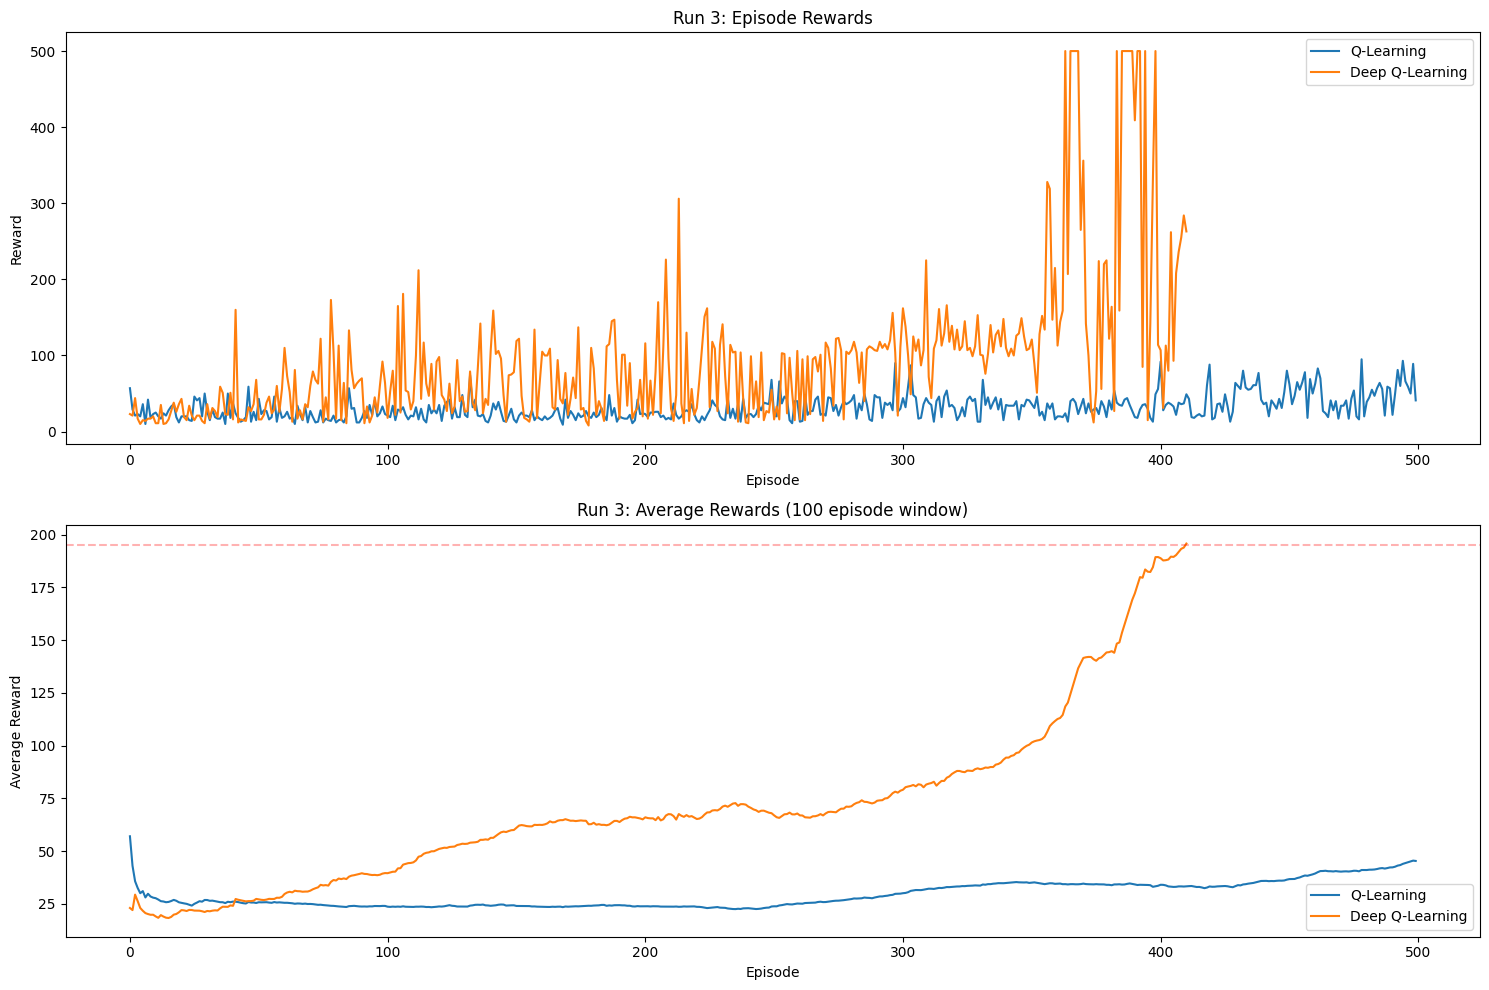


--- Benchmark Summary ---

Average Results over 3 runs:

Episodes to Solve:
  Q-Learning:     500.00 ± 0.00
  Deep Q-Learning: 359.00 ± 52.56

Final Avg Reward:
  Q-Learning:     51.72 ± 10.53
  Deep Q-Learning: 196.39 ± 0.42

Memory Usage (MB):
  Q-Learning:     0.28 ± 0.24
  Deep Q-Learning: 152.96 ± 56.01

Training Time (s):
  Q-Learning:     2.04 ± 0.13
  Deep Q-Learning: 13096.31 ± 1776.52


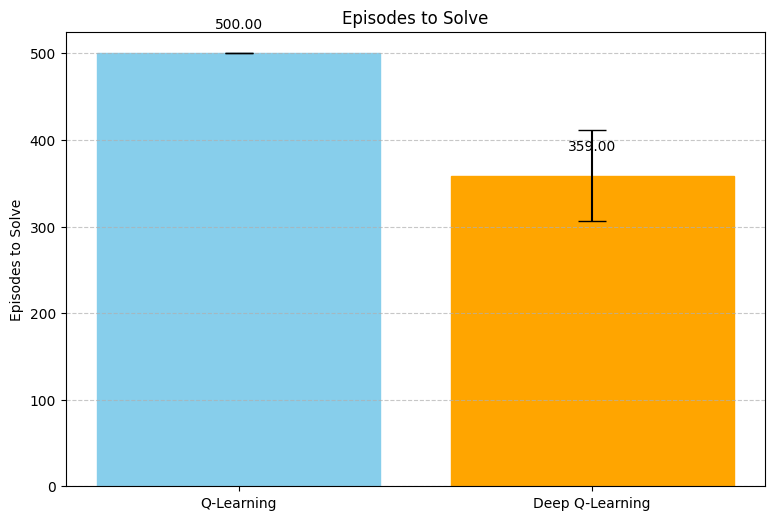

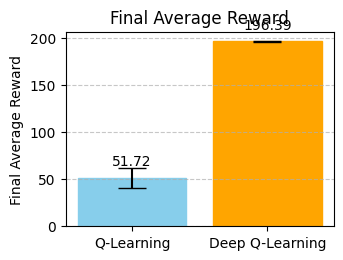

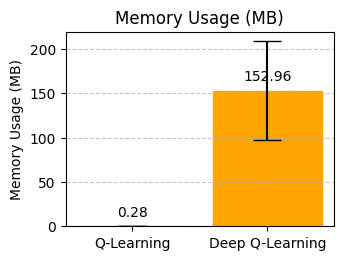

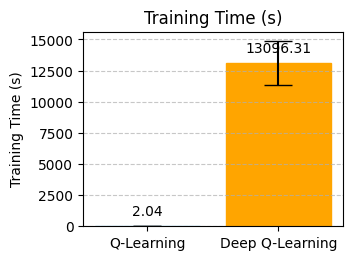


Benchmark complete! Results saved to PNG files.


In [ ]:
"""
Comparison of Q-Learning and Deep Q-Networks (DQN) for Reinforcement Learning
========================================================================

This code implements both traditional Q-Learning and Deep Q-Networks (DQN)
algorithms on the CartPole-v1 environment from OpenAI Gym/Gymnasium. We benchmark
both approaches by comparing:

1. Learning speed (episodes to solve)
2. Final performance (average rewards)
3. Memory usage
4. Training time

Requirements:
- gymnasium
- numpy
- tensorflow
- matplotlib
- psutil
- tqdm
"""

import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import random
import os
from collections import deque
from tqdm import tqdm

# Try to import gymnasium (new version) with fallback to gym (old version)
try:
    import gymnasium as gym
    print("Using Gymnasium (new version)")
    USING_GYMNASIUM = True
except ImportError:
    import gym
    print("Using Gym (old version)")
    USING_GYMNASIUM = False

# TensorFlow for Deep Q-Networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Memory tracking function
def get_memory_usage():
    """Return the memory usage in MB."""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / 1024 / 1024  # Convert to MB

class QLearningAgent:
    """Traditional Q-Learning with discretized state space."""

    def __init__(self, env, bins_per_dimension=10, learning_rate=0.1, discount_factor=0.99,
                 exploration_rate=1.0, exploration_decay=0.995, min_exploration_rate=0.01):
        self.env = env
        self.bins_per_dimension = bins_per_dimension
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate

        # Determine state and action space
        self.n_actions = env.action_space.n
        self.state_dimensions = env.observation_space.shape[0]

        # Create bins for discretizing continuous state space
        self.state_bins = []
        for i in range(self.state_dimensions):
            state_low = env.observation_space.low[i]
            state_high = env.observation_space.high[i]

            # Handle infinite bounds
            if state_low == float('-inf'):
                state_low = -5.0  # Reasonable limit for CartPole
            if state_high == float('inf'):
                state_high = 5.0  # Reasonable limit for CartPole

            self.state_bins.append(np.linspace(state_low, state_high, bins_per_dimension))

        # Initialize Q-table
        q_table_shape = tuple([bins_per_dimension] * self.state_dimensions + [self.n_actions])
        self.q_table = np.zeros(q_table_shape)

    def discretize_state(self, state):
        """Convert continuous state to discretized state index tuple."""
        discretized_state = []
        for i, s in enumerate(state):
            bin_index = np.digitize(s, self.state_bins[i]) - 1
            # Ensure index is within range
            bin_index = max(0, min(bin_index, self.bins_per_dimension - 1))
            discretized_state.append(bin_index)

        return tuple(discretized_state)

    def select_action(self, state):
        """Select action using epsilon-greedy policy."""
        if np.random.random() < self.exploration_rate:
            return self.env.action_space.sample()  # Explore
        else:
            discretized_state = self.discretize_state(state)
            return np.argmax(self.q_table[discretized_state])  # Exploit

    def update(self, state, action, reward, next_state, done):
        """Update Q-table using the Q-learning update rule."""
        discretized_state = self.discretize_state(state)
        discretized_next_state = self.discretize_state(next_state)

        # Q-learning update formula
        if not done:
            best_next_action = np.argmax(self.q_table[discretized_next_state])
            target = reward + self.discount_factor * self.q_table[discretized_next_state][best_next_action]
        else:
            target = reward

        # Update Q-value
        current_q = self.q_table[discretized_state][action]
        self.q_table[discretized_state][action] = current_q + self.learning_rate * (target - current_q)

        # Decay exploration rate
        if done:
            self.exploration_rate = max(
                self.min_exploration_rate,
                self.exploration_rate * self.exploration_decay
            )

    def train(self, episodes=1000, max_steps=500, render=False, stop_at_threshold=True):
        """Train the agent for a given number of episodes."""
        rewards_history = []
        avg_rewards_history = []
        steps_history = []

        # Define success threshold
        success_threshold = 195  # CartPole is considered solved if average reward is 195+ over 100 episodes
        success_window = deque(maxlen=100)

        for episode in tqdm(range(episodes), desc="Q-Learning Training"):
            # Handle different gym/gymnasium APIs
            if USING_GYMNASIUM:
                state, _ = self.env.reset()
            else:
                state = self.env.reset()

            episode_reward = 0

            for step in range(max_steps):
                if render:
                    self.env.render()

                action = self.select_action(state)

                # Handle different gym/gymnasium APIs
                if USING_GYMNASIUM:
                    next_state, reward, terminated, truncated, _ = self.env.step(action)
                    done = terminated or truncated
                else:
                    next_state, reward, done, _ = self.env.step(action)

                self.update(state, action, reward, next_state, done)

                state = next_state
                episode_reward += reward

                if done:
                    break

            rewards_history.append(episode_reward)
            success_window.append(episode_reward)
            avg_reward = np.mean(success_window)
            avg_rewards_history.append(avg_reward)
            steps_history.append(step + 1)

            # Check if environment solved
            if stop_at_threshold and len(success_window) >= 100 and avg_reward >= success_threshold:
                print(f"Environment solved in {episode+1} episodes!")
                break

        return rewards_history, avg_rewards_history, steps_history, episode+1

class DeepQLearningAgent:
    """Deep Q-Learning with neural network function approximation."""

    def __init__(self, env, learning_rate=0.001, discount_factor=0.99,
                 exploration_rate=1.0, exploration_decay=0.995, min_exploration_rate=0.01,
                 memory_size=10000, batch_size=64, update_target_frequency=100):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.update_target_frequency = update_target_frequency

        # Determine state and action space
        self.state_dim = env.observation_space.shape[0]
        self.n_actions = env.action_space.n

        # Initialize replay memory
        self.memory = deque(maxlen=memory_size)

        # Build main and target networks
        self.main_network = self._build_network()
        self.target_network = self._build_network()
        self.update_target_network()

        # Training steps counter
        self.training_steps = 0

    def _build_network(self):
        """Create a neural network for Q-function approximation."""
        model = Sequential([
            Dense(24, activation='relu', input_shape=(self.state_dim,)),
            Dense(24, activation='relu'),
            Dense(self.n_actions, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_network(self):
        """Copy weights from main network to target network."""
        self.target_network.set_weights(self.main_network.get_weights())

    def select_action(self, state):
        """Select action using epsilon-greedy policy."""
        if np.random.random() < self.exploration_rate:
            return self.env.action_space.sample()  # Explore
        else:
            state_tensor = np.reshape(state, [1, self.state_dim])
            q_values = self.main_network.predict(state_tensor, verbose=0)[0]
            return np.argmax(q_values)  # Exploit

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory."""
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        """Train main network using random samples from replay memory."""
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([transition[0] for transition in minibatch])
        actions = np.array([transition[1] for transition in minibatch])
        rewards = np.array([transition[2] for transition in minibatch])
        next_states = np.array([transition[3] for transition in minibatch])
        dones = np.array([transition[4] for transition in minibatch])

        # Predict current Q-values and next Q-values from target network
        target_qs = self.main_network.predict(states, verbose=0)
        next_qs = self.target_network.predict(next_states, verbose=0)

        # Update Q-values for the actions taken
        for i in range(self.batch_size):
            if dones[i]:
                target_qs[i, actions[i]] = rewards[i]
            else:
                target_qs[i, actions[i]] = rewards[i] + self.discount_factor * np.max(next_qs[i])

        # Train the main network
        self.main_network.fit(states, target_qs, epochs=1, verbose=0)

        # Increment counter and update target network if needed
        self.training_steps += 1
        if self.training_steps % self.update_target_frequency == 0:
            self.update_target_network()

    def train(self, episodes=1000, max_steps=500, render=False, stop_at_threshold=True):
        """Train the agent for a given number of episodes."""
        rewards_history = []
        avg_rewards_history = []
        steps_history = []

        # Define success threshold
        success_threshold = 195  # CartPole is considered solved if average reward is 195+ over 100 episodes
        success_window = deque(maxlen=100)

        for episode in tqdm(range(episodes), desc="Deep Q-Learning Training"):
            # Handle different gym/gymnasium APIs
            if USING_GYMNASIUM:
                state, _ = self.env.reset()
            else:
                state = self.env.reset()

            episode_reward = 0

            for step in range(max_steps):
                if render:
                    self.env.render()

                action = self.select_action(state)

                # Handle different gym/gymnasium APIs
                if USING_GYMNASIUM:
                    next_state, reward, terminated, truncated, _ = self.env.step(action)
                    done = terminated or truncated
                else:
                    next_state, reward, done, _ = self.env.step(action)

                self.remember(state, action, reward, next_state, done)
                self.replay()

                state = next_state
                episode_reward += reward

                if done:
                    break

            rewards_history.append(episode_reward)
            success_window.append(episode_reward)
            avg_reward = np.mean(success_window)
            avg_rewards_history.append(avg_reward)
            steps_history.append(step + 1)

            # Decay exploration rate
            self.exploration_rate = max(
                self.min_exploration_rate,
                self.exploration_rate * self.exploration_decay
            )

            # Check if environment solved
            if stop_at_threshold and len(success_window) >= 100 and avg_reward >= success_threshold:
                print(f"Environment solved in {episode+1} episodes!")
                break

        return rewards_history, avg_rewards_history, steps_history, episode+1

def run_benchmark(env_name='CartPole-v1', episodes=1000, runs=3):
    """Run and benchmark both algorithms on the same environment."""
    # Results storage
    q_learning_results = {
        'episodes_to_solve': [],
        'final_avg_reward': [],
        'memory_usage': [],
        'training_time': []
    }

    dq_learning_results = {
        'episodes_to_solve': [],
        'final_avg_reward': [],
        'memory_usage': [],
        'training_time': []
    }

    for run in range(runs):
        print(f"\n--- Run {run+1}/{runs} ---")

        # Q-Learning
        print("\nTraditional Q-Learning:")
        if USING_GYMNASIUM:
            env = gym.make(env_name)
        else:
            env = gym.make(env_name, render_mode=None)

        memory_before = get_memory_usage()
        start_time = time.time()

        q_agent = QLearningAgent(env, bins_per_dimension=10)
        q_rewards, q_avg_rewards, q_steps, q_episodes = q_agent.train(episodes=episodes)

        training_time = time.time() - start_time
        memory_usage = get_memory_usage() - memory_before

        q_learning_results['episodes_to_solve'].append(q_episodes)
        q_learning_results['final_avg_reward'].append(np.mean(q_rewards[-100:]))
        q_learning_results['memory_usage'].append(memory_usage)
        q_learning_results['training_time'].append(training_time)

        print(f"Q-Learning Results:")
        print(f"  Episodes to solve: {q_episodes}")
        print(f"  Final average reward: {np.mean(q_rewards[-100:]):.2f}")
        print(f"  Memory usage: {memory_usage:.2f} MB")
        print(f"  Training time: {training_time:.2f} seconds")

        # Deep Q-Learning
        print("\nDeep Q-Learning:")
        if USING_GYMNASIUM:
            env = gym.make(env_name)
        else:
            env = gym.make(env_name, render_mode=None)

        memory_before = get_memory_usage()
        start_time = time.time()

        dq_agent = DeepQLearningAgent(env)
        dq_rewards, dq_avg_rewards, dq_steps, dq_episodes = dq_agent.train(episodes=episodes)

        training_time = time.time() - start_time
        memory_usage = get_memory_usage() - memory_before

        dq_learning_results['episodes_to_solve'].append(dq_episodes)
        dq_learning_results['final_avg_reward'].append(np.mean(dq_rewards[-100:]))
        dq_learning_results['memory_usage'].append(memory_usage)
        dq_learning_results['training_time'].append(training_time)

        print(f"Deep Q-Learning Results:")
        print(f"  Episodes to solve: {dq_episodes}")
        print(f"  Final average reward: {np.mean(dq_rewards[-100:]):.2f}")
        print(f"  Memory usage: {memory_usage:.2f} MB")
        print(f"  Training time: {training_time:.2f} seconds")

        # Plot learning curves for this run
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 1, 1)
        plt.plot(q_rewards, label='Q-Learning')
        plt.plot(dq_rewards, label='Deep Q-Learning')
        plt.title(f'Run {run+1}: Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(q_avg_rewards, label='Q-Learning')
        plt.plot(dq_avg_rewards, label='Deep Q-Learning')
        plt.title(f'Run {run+1}: Average Rewards (100 episode window)')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.axhline(y=195, color='r', linestyle='--', alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.show()


    # Calculate averages
    for metric in q_learning_results:
        q_learning_results[metric] = {
            'mean': np.mean(q_learning_results[metric]),
            'std': np.std(q_learning_results[metric])
        }
        dq_learning_results[metric] = {
            'mean': np.mean(dq_learning_results[metric]),
            'std': np.std(dq_learning_results[metric])
        }

    # Create summary table and plots
    print("\n--- Benchmark Summary ---")
    print("\nAverage Results over", runs, "runs:")

    metrics = ['episodes_to_solve', 'final_avg_reward', 'memory_usage', 'training_time']
    labels = ['Episodes to Solve', 'Final Avg Reward', 'Memory Usage (MB)', 'Training Time (s)']

    for metric, label in zip(metrics, labels):
        q_mean = q_learning_results[metric]['mean']
        q_std = q_learning_results[metric]['std']
        dq_mean = dq_learning_results[metric]['mean']
        dq_std = dq_learning_results[metric]['std']

        print(f"\n{label}:")
        print(f"  Q-Learning:     {q_mean:.2f} ± {q_std:.2f}")
        print(f"  Deep Q-Learning: {dq_mean:.2f} ± {dq_std:.2f}")

    # Create bar chart comparison
    plot_comparison(q_learning_results, dq_learning_results)

    return q_learning_results, dq_learning_results

def plot_comparison(q_results, dq_results):
    """Create comparison plots for the benchmark results."""
    metrics = ['episodes_to_solve', 'final_avg_reward', 'memory_usage', 'training_time']
    labels = ['Episodes to Solve', 'Final Average Reward', 'Memory Usage (MB)', 'Training Time (s)']

    plt.figure(figsize=(15, 10))

    for i, (metric, label) in enumerate(zip(metrics, labels), 1):
        plt.subplot(2, 2, i)

        algorithms = ['Q-Learning', 'Deep Q-Learning']
        means = [q_results[metric]['mean'], dq_results[metric]['mean']]
        stds = [q_results[metric]['std'], dq_results[metric]['std']]

        bars = plt.bar(algorithms, means, yerr=stds, capsize=10)
        bars[0].set_color('skyblue')
        bars[1].set_color('orange')

        plt.title(label)
        plt.ylabel(label)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add values on top of bars
        for bar, mean in zip(bars, means):
            plt.text(bar.get_x() + bar.get_width()/2, mean + 0.05*max(means),
                    f'{mean:.2f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    # Run benchmark
    q_results, dq_results = run_benchmark(env_name='CartPole-v1', episodes=500, runs=3)

    print("\nBenchmark complete! Results saved to PNG files.")